# Time-series forecasting: Using 2 approaches: 1) Long-Short Term Memory (LSTM) & 2) Prophet (The Facebook's additive reggresion model).

* The first approach (LSTM) is an artificial recurrent neural network (RNN) used in the field of deep learning for time-series forecasting due to its capacity to store information over a given period of time.

* On the other hand, the Facebook's model: Prophet was made in an attempt to develop a model that could capture seasonality in time-series data. Its able to capture daily, weekly and yearly seasonality along with holiday effects, by implementing additive regression models.

## The dataset

For this exercise, we'll use the stock price history of Google from the Yahoo finance site.
Download dataset [HERE](https://finance.yahoo.com/quote/GOOG/history?period1=1433548800&period2=1591833600&interval=1d&filter=history&frequency=1d) or simply use the file in the ./data directory.

## The Code

### Import required libraries

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

### Load Dataset

In [71]:
df=pd.read_csv("./data/data.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1240, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,7/9/2015,51.816002,52.590000,51.358002,51.584000,51.584000,16670500
1,7/10/2015,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
2,7/13/2015,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
3,7/14/2015,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
4,7/15/2015,53.348000,53.498001,52.416000,52.627998,52.627998,10108000


### Split dataset into train and test.

In [72]:
#Training set is composed of the first 800 points in the time-series.
training_set = df.iloc[:800, 1:2].values
#Test set is composed by the next 519 values
test_set = df.iloc[800:, 1:2].values
print('Data points on training set:', training_set.shape)
print('Data points on test set:', test_set.shape)

Data points on training set: (800, 1)
Data points on test set: (440, 1)


# >>>>> LTSM Approach <<<<<

For this exercise, we're using 60 time steps and 1 output. This is, we're training the model to forecast the point after a given 60 points time-series.

### Data normalization

Normalizing data before model fitting may boost the performance. In this case, we use the min-max normalization.

In [73]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1)) #Min-max normalization
#Normalize training set
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800): #Remember trianing set is composed of 1000 points
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape) #--> After the 740th position there are no more values to create a 60 values time-series.

#At this point, we have reshaped the data into the following format (#values, #time-steps, #1 dimensional output).

(740, 60, 1)


### Build the model

The model is composed by 60 inputs, 4 hidden layers & 1 neuron in the output layer to predict the normalized stock price. It uses the MSE loss function and the Adam stochastic gradient descent optimizer.

In [74]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


### Train the model

In [75]:
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 5s 42ms/step - loss: 0.1351
Epoch 2/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0176
Epoch 3/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0118
Epoch 4/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0123
Epoch 5/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0117
Epoch 6/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0108
Epoch 7/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0109
Epoch 8/100
24/24 [==============================] - 1s 45ms/step - loss: 0.0127
Epoch 9/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0112
Epoch 10/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0106
Epoch 11/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0093
Epoch 12/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0109
Epoch 13/100
24/24 [=====

### Prepare test data (reshape and normalize)

In [77]:
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 440): ##519 values on test data set
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (380, 60, 1)

(380, 60, 1)


### Make the predictions using the test data set.

In [78]:
#Get normalized predictions
predicted_stock_price = model.predict(X_test)
#Denormalize values to get the actual predicted stock price.
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#predicted_stock_price = pd.DataFrame(predicted_stock_price)



### Visualize prediction results (Using LTSM)

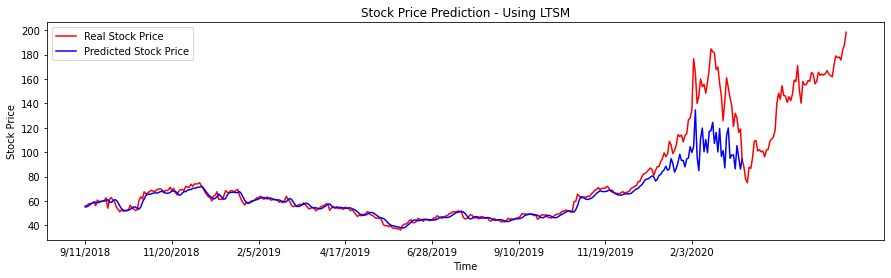

In [82]:
plt.figure(figsize=(15,4))
plt.plot(df.loc[800:, 'Date'],dataset_test.values, color = 'red', label = 'Real Stock Price')
plt.plot(df.loc[800:1179, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.xticks(np.arange(0,380,50))
plt.title('Stock Price Prediction - Using LTSM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# >>>>> Prophet Approach <<<<<

For this exercise, we will only use the dates and the Close price as features for our model. No need for normalization since the model is already able to do it for ourselves.

In order to use the Prophet model we can simply install it by running:
> pip install fbprophet

In [2]:
#Read dataset
df=pd.read_csv("./data/data.csv")
print('Number of rows and columns:', df.shape)
 
# Select only the important features i.e. the date and price
data = df[["Date","Close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"Date":"ds","Close":"y"}) #renaming the columns of the dataset
data.head(5)

Number of rows and columns: (1240, 7)


,ds,y
0,7/9/2015,51.584000
1,7/10/2015,51.830002
2,7/13/2015,52.431999
3,7/14/2015,53.130001
4,7/15/2015,52.627998


### Import the model

In [3]:
from fbprophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data) # fit the model using all data

Importing plotly failed. Interactive plots will not work.


### Predict the future datapoints

The model predicts 365 days on the future (from june 2020 to june 2021). Blue line is the predicted price and blue shadow is the confidential interval.

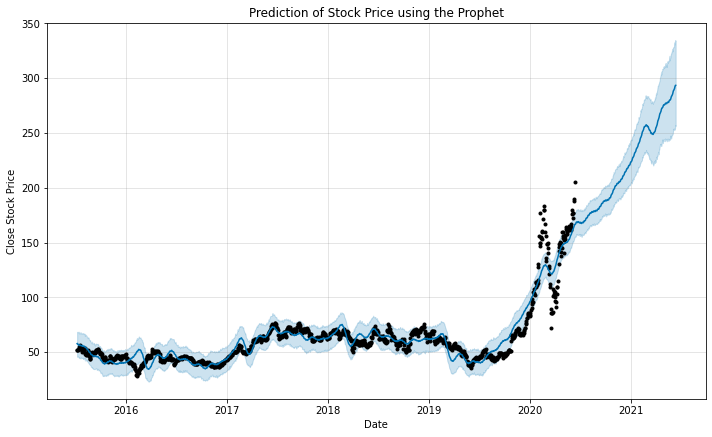

In [5]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

#### Side note: Opossite to our LTSM implementation, in this case, we cannot measure the error of the model. If we want to do that, then we should split the data into training and test sets, fit the model using the training set only, predict the prices of the test set and then measure the error using the ground truth price values of the test set.